# CMPINF0010: What is the best Pittsburgh Neighborhood?
Team Graffiti

Members: Jared Peters and Zack Feerrar

---
# Metric 1: Safety
By Jared Peters

## Datasets
- [Police Incident Blotter (30 Day)](https://data.wprdc.org/dataset/police-incident-blotter)
- [Pittsburgh American Community Survey 2015 - Total Population](https://data.wprdc.org/dataset/pittsburgh-american-community-survey-2015-miscellaneous-data/resource/82f29015-6905-4b1c-8300-afe9bb2231b3)

### Step 1: Setup
- Import pandas and matplotlib
- Import blotter dataframe
- Refine dataset columns

In [ ]:
import pandas as pd
# % matplotlib inline

In [ ]:
# Import online Blotter data
blotter_data = pd.read_csv("https://data.wprdc.org/datastore/dump/1797ead8-8262-41cc-9099-cbc8a161924b")
blotter_data.columns

There are many columns, but we only need a few.

In [ ]:
# Filter out unnecessary columns
blotter_data = blotter_data[['INCIDENTNEIGHBORHOOD', 'INCIDENTHIERARCHYDESC']]
blotter_data.head(10)

### Step 2: Determine Danger Level
- Create a function to weigh incidents based on their severity

There are too many incident types to weight each one

In [ ]:
# Count the unique incident types
blotter_data['INCIDENTHIERARCHYDESC'].nunique()

We can look at the most common and group them by severity

In [ ]:
# Let's take the top 15 and group them into categories for their severity
blotter_data['INCIDENTHIERARCHYDESC'].value_counts().head(20)

Most of them can be seen as moderate, but some are more minor or severe

In [ ]:
severe_incidents = ["BURGLARY", "DEAD ON ARRIVAL (DOA)"]
minor_incidents = ["99", "CRIM MISCHIEF", "RETAIL THEFT (SHOPLIFTING)"]
# Any other incidents will be considered moderate

We'll now make a 'DANGER_LEVEL' column to describe the weighted rating of the offense

In [ ]:
def get_incident_weight(incident: str):
    if incident in severe_incidents:
        return 150
    if incident in minor_incidents:
        return 75
    return 100

blotter_data['DANGER_LEVEL'] = blotter_data['INCIDENTHIERARCHYDESC'].map(get_incident_weight)
blotter_data.head()

Once we have these danger levels, we can group the data by Neighborhood and aggregate by their total danger level.

In [ ]:
nb_groups = blotter_data.groupby('INCIDENTNEIGHBORHOOD')
neighborhood_data = nb_groups.agg({'DANGER_LEVEL':'sum'})
neighborhood_data.head()

Here are the top 10 safest and most dangerous neighborhoods, based purely on DANGER_LEVEL

In [ ]:
neighborhood_data = neighborhood_data.sort_values(by="DANGER_LEVEL")
neighborhood_data['DANGER_LEVEL'].head(10).plot.bar(xlabel='Safest Neighborhoods', ylabel='Danger per Capita')

In [ ]:
neighborhood_data['DANGER_LEVEL'].tail(10).plot.bar(xlabel="Most Dangerous Neighborhoods", ylabel='Danger per Capita')

## Step 3: Account for Population
This data still may not be a fair indicator, as higher populations will tend to have more crime due to having more people.

We can account for this by importing estimated population data.

In [ ]:
population_data = pd.read_csv('https://data.wprdc.org/dataset/5b18c198-474c-4723-b735-cc5220ad43cc/resource/82f29015-6905-4b1c-8300-afe9bb2231b3/download/total-population.csv', index_col='Neighborhood')
population_data.head()

We can add the 'Estimate; Total' data to our current neighborhood data by creating a new column.

In [ ]:
neighborhood_data['POPULATION'] = population_data['Estimate; Total']
neighborhood_data.head()

Now, we can join our dataframes and create a new column for danger level per capita

In [ ]:
neighborhood_data['DANGER_PER_CAPITA'] = neighborhood_data['DANGER_LEVEL'] / neighborhood_data['POPULATION']
neighborhood_data.head()

## Conclusion

This 'DANGER_PER_CAPITA' can be used as our indicator for safety, so let's look at the most and least safe neighborhoods

In [ ]:
neighborhood_data = neighborhood_data.sort_values(by="DANGER_PER_CAPITA").dropna()
neighborhood_data['DANGER_PER_CAPITA'].head(10).plot.bar(xlabel='Safest Neighborhoods', ylabel='Danger per Capita')

In [ ]:
neighborhood_data['DANGER_PER_CAPITA'].tail(10).plot.bar(xlabel="Most Dangerous Neighborhoods", ylabel='Danger per Capita')

Woah! Why is Chateau's danger rating so high?

Chateau has a very small is population (Only 3, according to our population dataset), and mainly consists of [warehouses](https://en.wikipedia.org/wiki/Chateau_(Pittsburgh)), so it could be possible that people go to this unpopulated neighborhood to stay under the radar and commit crime

South Shore also similarly has a small population (12) and consists of many warehouses.

Based on calculations including the amount of police incidents reported, the type of incidents, and the neighborhood populations, the final rankings from safest to most dangerous are as follows:

In [ ]:
# Print each of the neighborhoods (the index of the df) on separate lines in order
for rank, nb in enumerate(neighborhood_data.index, 1):
    print(f"{rank}. {nb}")

---
# Metric 2: Public Art
 By Zachariah Feerrar

## Dataset:
Public art: https://data.wprdc.org/dataset/city-of-pittsburgh-public-art

## Introduction

I chose public art as my metric because it gives a neighborhood life. There is history behind each piece that could be explored too. This can attract more guests, as it something to fill time viewing and exploring. The more art, the more people come in and out. Word can spread about the amount of art in a neighborhood too, giving it more popularity overall.

## Setup

I imported pandas, matplotlib, and the public art dataframe.

In [ ]:
#imports
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt

I also filtered the information to only neighborhoods and art types, since those are the only columns we will be using.

In [ ]:
#Data is being read through csv file
parks = pd.read_csv("https://data.wprdc.org/datastore/dump/00d74e83-8a23-486e-841b-286e1332a151",
                           index_col="title",
                           parse_dates=True)

#Filter information so it only lists each art project, neighborhood, and art type in Pittsburgh
parks = parks[['neighborhood', 'art_type']]
parks['neighborhood'] = parks['neighborhood'].fillna('Unknown')
parks['art_type'] = parks['art_type'].fillna('Unknown')
parks.head(100)

## Determining which neighborhood has the most public art

I started by grouping the neighborhoods and art types together to make a table showing how many times they were used in the dataframe. I also filled the NaN values with 0 so they are included in the dataset.

In [ ]:
park = pd.DataFrame(parks.groupby(["neighborhood", "art_type"]).size().unstack().fillna(0))
park

I then made a bar graph, as the information is easier to read. The different colors are for each art type. The art that didn't have a neighborhood or art type is "Unknown" on the graph.

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
park.plot.bar(stacked=True,ax=ax)
plt.xlabel("Neighborhood")
plt.legend(title='Art Type')

## Conclusion
As you can see, Central Business District has the most public art in Pittsburgh. This makes it the best according to my metric. It isn't really surprising, as it is downtown and is visited more frequently by guests.

The "worst" neighborhood is shared by several neighborhoods, such as Hays and Polish Hill, with a shared amount of 1 public art project.

---
# Combining the Data
In order to combine our data, we will create standardized ratings for each metric.

We can do this by dividing each metric's numerical value by their max.

## Safety Rating
We will start by getting a standard rating for the danger of each neighborhood.

Typically, this could be done by dividing each DANGER_PER_CAPITA by the max DANGER_PER_CAPITA, but since we have 2 outliers we will divide by the 3rd largest DANGER_PER_CAPITA.

In [ ]:
# The "max" here is actually the 3rd largest, since we want to ignore the outliers
max_danger_per_capita = neighborhood_data["DANGER_PER_CAPITA"][-3]
neighborhood_data["DANGER_RATING"] = neighborhood_data["DANGER_PER_CAPITA"] / max_danger_per_capita

Now to get a rating for safety, we can just take 1 - DANGER_RATING, since the values fall between [0, 1] (other than the outliers)

In [ ]:
neighborhood_data["SAFETY_RATING"] = 1 - neighborhood_data["DANGER_RATING"]
neighborhood_data

## Art Project Weighting

For each neighborhood, we divided the amount of art projects in that neighborhood by the max amount, which was Central Business District's 27 projects. A column was added to the data table showing the weight of the neighborhoods compared to the best one from that metric.

In [ ]:
max_public_art = parks['neighborhood'].value_counts().sort_values(ascending=False)[0]
park['weight'] = parks['neighborhood'].value_counts()/max_public_art
park

## Making the Final Dataframe
We can now finalize our dataframe with only the art and safety ratings.

Since safety is typically more important when deciding a neighborhood to live in, it will have twice the weight.

In [ ]:
final_df = pd.DataFrame(neighborhood_data["SAFETY_RATING"])
final_df['ART_RATING'] = park['weight']

# Give any missing values a weight of 0 (Such as those with no data on art)
final_df = final_df.fillna(0)

# We will double every SAFETY_RATING, in order to give it twice as much value
final_df['SAFETY_RATING'] = final_df['SAFETY_RATING'] * 2

# Create a TOTAL_RATING column as a sum of both ratings, with twice the weight on safety
final_df['TOTAL_RATING'] = final_df['SAFETY_RATING'] + final_df['ART_RATING']

# Sort based on the new rating
final_df = final_df.sort_values(by='TOTAL_RATING', ascending=False)

final_df

# Final Conclusion

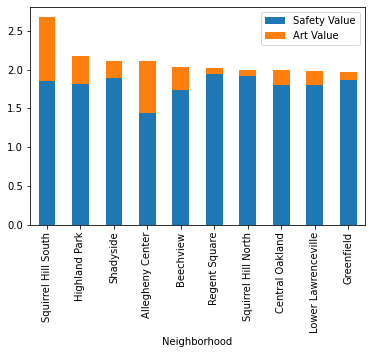

In [241]:
final_df[['SAFETY_RATING', 'ART_RATING']].head(10).plot.bar(stacked=True, xlabel="Neighborhood").legend(["Safety Value", "Art Value"])

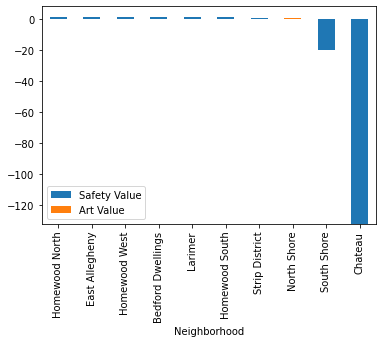

In [244]:
final_df[['SAFETY_RATING', 'ART_RATING']].tail(10).plot.bar(stacked=True, xlabel="Neighborhood").legend(["Safety Value", "Art Value"])

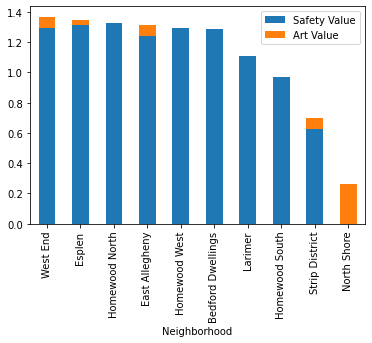

In [243]:
final_df[['SAFETY_RATING', 'ART_RATING']][:-2].tail(10).plot.bar(stacked=True, xlabel="Neighborhood").legend(["Safety Value", "Art Value"])